# Loading the mass sepctrum


In [83]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

import matplotlib.ticker as tck
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter, find_peaks
import pandas as pd
plt.style.use('seaborn-white')
#plt.style.use('ggplot')  its nice!
plt.rcParams['font.family'] = 'arial'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 25
plt.rcParams['axes.labelsize'] = 25
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 25
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25
plt.rcParams['legend.fontsize'] = 25
plt.rcParams['figure.titlesize'] = 25
def peak_finder(mass, dis, h, p):    
    x=mass.iloc[:,0][1000:200000]
    counts= mass.iloc[:,1][1000:200000]
    y= np.log(mass.iloc[:,1])[1000:200000]
    peaks, _ = find_peaks(y, distance=dis, height=h, prominence=p)#5(log_counts, distance=2, height=2, prominence=0.6)
    fig, ax = plt.subplots(figsize=(20, 5))
    ax.plot(x,y, color='k')
    ax.scatter(x.iloc[peaks],y.iloc[peaks], color='r',s = 20)
    plt.xlabel('Mass-to-charge ratio [m/z[)]')
    plt.ylabel('Count [log]')
    ax.minorticks_on()
    ax.tick_params(direction='out',axis='both',  which ='major',length=6, width=2, colors='black',
                   grid_color='black', grid_alpha=0.5)
    ax.tick_params(direction='out',axis='both',  which ='minor',length=4, width=2, colors='black')
    ax.xaxis.set_major_locator(MultipleLocator(10))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    
    # For the minor ticks, use no labels; default NullFormatter.
    ax.xaxis.set_minor_locator(MultipleLocator(5))    
    plt.xlim(0, max(x.iloc[peaks]+10))
    plt.ylim(0,15)  
    plt.grid(linestyle='dotted')
    y=y.reset_index(drop=True)
    new_mass= pd.concat([x.iloc[peaks], counts.iloc[peaks]],axis=1, ignore_index=True, sort =False)
    new_mass.columns = ['m','count']
    return new_mass


Original data has 674427 rows and 4 columns

In [84]:

mass = pd.read_csv('/content/mass_spectra_HEA.csv')
print(mass)


        Mass to Charge State Ratio (Da)  ...   Background Count
0                                0.0000  ...       10511.330000
1                                0.0010  ...        6068.722000
2                                0.0020  ...        4700.812000
3                                0.0030  ...        3972.911000
4                                0.0040  ...        3503.779000
...                                 ...  ...                ...
674422                         674.4221  ...           9.050590
674423                         674.4230  ...           9.050583
674424                         674.4240  ...           9.050576
674425                         674.4250  ...           9.050570
674426                         674.4260  ...           9.050563

[674427 rows x 4 columns]


/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


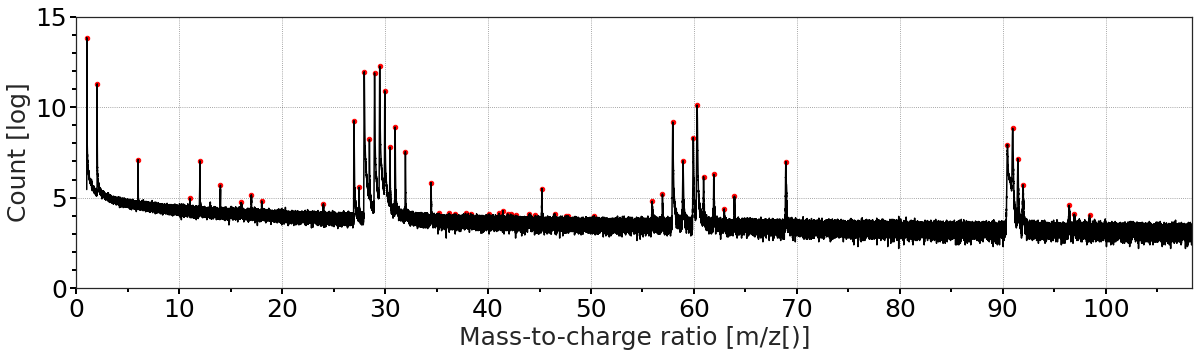

In [85]:
dis=100
h=4
p = 1
mass_peaks = peak_finder(mass, dis, h, p)

**Peaks of mass spectra as input**

In [86]:
print(mass_peaks)

              m    count
1007    1.00700  1012876
2015    2.01500    79183
5996    5.99600     1215
11012  11.01200      144
11997  11.99700     1133
13989  13.98900      295
16021  16.02100      114
16994  16.99400      173
18002  18.00200      124
23999  23.99900      106
26970  26.97000    10369
27466  27.46600      265
27967  27.96700   154368
28468  28.46800     3693
28967  28.96700   145054
29466  29.46600   210975
29965  29.96500    54019
30468  30.46800     2396
30964  30.96400     7323
31964  31.96400     1894
34458  34.45800      342
35254  35.25400       63
36218  36.21800       63
36776  36.77600       61
37809  37.80900       63
38310  38.31000       62
40040  40.04000       60
41065  41.06500       63
41452  41.45200       73
41917  41.91700       61
42193  42.19300       60
42689  42.68900       56
43979  43.97900       60
44594  44.59400       56
45230  45.23000      246
46454  46.45400       62
47589  47.58900       55
47760  47.76000       55
50311  50.31100       55



# Atomic pattern recognizer


In [126]:
# -*- coding: utf-8 -*-
"""
Created on Thu Jul 16 18:52:59 2020

@author: y.wei
"""
import pandas as pd
import os
import re
import numpy as np
import pickle

def round_up_values_higher_charge(test):
    new_test= []
    for n in test:
        temp=int(n)
#        print(temp)
    
        if n<=temp+0.2:
            new_n = temp
            new_test.append(new_n)   
        elif (n>temp+0.22 and n<=temp+0.27):
            new_n = temp+0.25
            new_test.append(new_n)  
        elif (n>temp+0.27 and n<=temp+0.35):
            new_n = temp+0.33
            new_test.append(new_n)      
        elif (n>temp+0.37 and n<=temp+0.6):
            new_n = temp+0.5
            new_test.append(new_n)
        elif (n>temp+0.6 and n<=temp+0.7):
            new_n = temp+0.67
            new_test.append(new_n)
        elif (n>temp+0.7 and n<=temp+0.8):
            new_n = temp+0.75   
            new_test.append(new_n)       
        else:
            new_n = temp+1   
            new_test.append(new_n)                   
    return new_test

class Atomic_pattern_recognizer(object):
  def __init__(self):
    self.three_peaks_names = ['Mg', 'S', 'Si', 'Fe', 'Ca_3P','double_S', 'double_B','Random_class_three', 'Ni_3P','Cr_3P']
    self.four_peaks_names = ['Cr', 'Zn', 'Fe', 'Ni', 'Zr','Ca','Random_class_four']
    self.five_peaks_names = ['Ti', 'Ni', 'Ge','Zn','Se','Zr','Random_class_five'] 
    self.seven_peaks_names = ['Ru', 'Mo', 'Sm', 'Nd', 'Gd', 'Yd','Random_class_seven']
    self.three_peak_classifier = pickle.load(open("/content/ML_models/lgb_model_three.pickle.dat", "rb"))
    self.four_peak_classifier = pickle.load(open("/content/ML_models/lgb_model_four.dat", "rb"))
    self.five_peak_classifier = pickle.load(open("/content/ML_models/lgb_model_five.pickle.dat", "rb"))
    self.seven_peak_classifier = pickle.load(open("/content/ML_models/lgb_model_seven.pickle.dat", "rb"))


  def three_peak_class(self, peak):
      x = {'P1': [peak['normalized_count'].iloc[0]], 'P2': [peak['normalized_count'].iloc[1]],
          'P3':[peak['normalized_count'].iloc[2]]}
      x1=pd.DataFrame(x)
      pred = self.three_peak_classifier.predict(x1)
      name = self.three_peaks_names[np.argmax(pred[0])]
      x1['std'] =x1.std(axis=1)

      return pred,name, x1 


  def four_peak_class(self, peak):
      x = {'P1': [peak['normalized_count'].iloc[0]], 'P2': [peak['normalized_count'].iloc[1]],
          'P3':[peak['normalized_count'].iloc[2]],'P4':[peak['normalized_count'].iloc[3]]}
      x1 = pd.DataFrame(x)
      x1['std'] =x1.std(axis=1)
      x1['P1/P2'] = x1['P1']/x1['P2']
      x1['P1/P3'] = x1['P1']/x1['P3']
      x1['P1/P4'] = x1['P1']/x1['P4']
      x1['P2/P3'] = x1['P2']/x1['P3']
      x1['P2/P4'] = x1['P2']/x1['P4']
      x1['P3/P4'] = x1['P3']/x1['P4']
      x2 = x1.drop(['P1','P2','P3','P4'],axis=1)
      pred = self.four_peak_classifier.predict(x2)
      name = self.four_peaks_names[np.argmax(pred[0])]
      return pred, name, x1    


  def five_peak_class(self, peak):
      x = {'P1': [peak['normalized_count'].iloc[0]], 'P2': [peak['normalized_count'].iloc[1]],
          'P3':[peak['normalized_count'].iloc[2]],'P4':[peak['normalized_count'].iloc[3]],
          'P5':[peak['normalized_count'].iloc[4]]}
      x1=pd.DataFrame(x)
      x1['std'] =x1.std(axis=1)
      pred = self.five_peak_classifier.predict(x1)
      name = self.five_peaks_names[np.argmax(pred[0])]
      return pred,name ,x1      


  def seven_peak_class(self, peak):
      x = {'P1': [peak['normalized_count'].iloc[0]], 'P2': [peak['normalized_count'].iloc[1]],
          'P3':[peak['normalized_count'].iloc[2]],'P4':[peak['normalized_count'].iloc[3]],
          'P5':[peak['normalized_count'].iloc[4]], 'P6':[peak['normalized_count'].iloc[5]],'P7':[peak['normalized_count'].iloc[6]]}                                                        
      x1=pd.DataFrame(x)
      x1['std'] =x1.std(axis=1)
      pred = self.seven_peak_classifier.predict(x1)
      name = self.seven_peaks_names[np.argmax(pred[0])]
      return pred,name ,x1  


  def MZ_ratio_match(self, frame, new_test):
      path = '/content/atomic_database'
      database = []
      database_std = []
      database_name = []
      for filename in os.listdir(path):
      #    print(filename)
          temp = pd.read_csv(path+'/'+filename)
          m = temp['m'].isin(new_test)
          cols = temp.index[m].tolist()
          comp = temp['Composition'].iloc[cols].tolist()
          # print(comp)
          if (len(cols)>=3 and sum(comp)>=99 and len(comp)>=3):
      #        print(x)
      #        print(frame[frame['Da'].isin(temp['m'][m])])      
              x=frame[frame['Da'].isin(temp['m'][m])]
              normalized_I=x['count']/sum(x['count'])*100        
              x['normalized_count'] = normalized_I 
              # print(x)
              # print(filename)
              std_comp =  temp['Composition'].std()
              std_temp = x['normalized_count'].std()        
              database.append(x)
              database_std.append(std_comp)
      #        print(m)
      #        print(len(m))
              fn = filename.split('.')
              database_name.append(fn[0])
      return database, database_std, database_name 


  def multi_peak_search(self, frame, new_test):    
      database, database_std, database_name =  MZ_ratio_match(frame, new_test)       
      name_pair =  []       
      predictions = []
      new_peaks = []       
      name_pair_uncertain =[]
      new_peaks_uncertain = []
      predictions_uncertain = [] 
      
      for name, peak, std in zip(database_name, database, database_std):   
          # print(name)
          if len(peak) == 3:
              # print(peak)
              prediction, pred_name, x  = three_peak_class(peak)
              print(pred_name)
              print(prediction)
              std_deviation = abs(x['std'][0]-std)/std
              if max(prediction[0])<=0.8:
                  x_uncertain = sorted(zip(prediction[0], three_peaks_names), reverse=True)[:3]
                  x__uncertain_pred = sorted(prediction[0], reverse=True)[:3]                
              if std_deviation <= 0.5 and max(prediction[0])>=0.8:
                  print(peak)
                  print(pred_name)
                  print('std is {}'.format(std))
                  print('deviation from std is {}'.format(std_deviation))
                  name_pair.append([pred_name,name]) 
                  predictions.append(prediction)
                  new_peaks.append(peak)
              elif(std_deviation <= 0.5 and max(prediction[0])<=0.8):
                  print(x)
                  print('std is {}'.format(std))
                  print('deviation from std is {}'.format(std_deviation))
                  name_pair_uncertain.append([x_uncertain[0][1],x_uncertain[1][1], x_uncertain[2][1], name]) 
                  predictions_uncertain.append(prediction)
                  new_peaks_uncertain.append(peak)                  
                  
          if len(peak) == 4:
              prediction, pred_name, x  = four_peak_class(peak)
              std_deviation = abs(x['std'][0]-std)/std
              if max(prediction[0])<=0.8:
                  x_uncertain = sorted(zip(prediction[0], four_peaks_names), reverse=True)[:3]
                  x__uncertain_pred = sorted(prediction[0], reverse=True)[:3]                
              if (std_deviation <= 0.5 and max(prediction[0])>=0.8):
                  print(peak)
                  print(pred_name)
                  # print('std is {}'.format(std))
                  # print('deviation from std is {}'.format(std_deviation))
                  name_pair.append([pred_name,name]) 
                  predictions.append(prediction)
                  new_peaks.append(peak)
              elif(std_deviation <= 0.5 and max(prediction[0])<=0.5):
                  print(x)
      #            print(peak)
                  print(pred_name)
                  print('std is {}'.format(std))
                  print('deviation from std is {}'.format(std_deviation))
                  name_pair_uncertain.append([x_uncertain[0][1],x_uncertain[1][1], x_uncertain[2][1], name]) 
                  predictions_uncertain.append(prediction)
                  new_peaks_uncertain.append(peak)            
                  
          if len(peak) == 5:
              prediction, pred_name, x  = five_peak_class(peak)
              print(pred_name)
              std_deviation = abs(x['std'][0]-std)/std
              print('std is {}'.format(std))
              print('deviation from std is {}'.format(std_deviation))
              if std_deviation <= 0.5:
                  name_pair.append([pred_name,name]) 
                  predictions.append(prediction)
                  new_peaks.append(peak)
                                  
          if len(peak) == 7:
              prediction, pred_name, x  = seven_peak_class(peak)
      #        print(pred_name)
              std_deviation = abs(x['std'][0]-std)/std
              print('std is {}'.format(std))
              print('deviation from std is {}'.format(std_deviation))
              if std_deviation <= 0.5:
                  name_pair.append([pred_name,name]) 
                  predictions.append(prediction)
                  new_peaks.append(peak)                 
                  
      elements_three_or_more_peak=[]
      for item in name_pair:
          if item[0] == item[1]:
              print('Element {} is confirmed!'.format(item[0]))
              elements_three_or_more_peak.append(item[1])
          if item[0] in item[1]:
                  print('Element {} is confirmed!'.format(item[1]))
                  elements_three_or_more_peak.append(item[1])
      if len(name_pair_uncertain)>0:
          print('there are peaks with uncertainies!')
          all_elements_uncertain = [name_pair_uncertain, new_peaks_uncertain, predictions_uncertain]            
      else:
          all_elements_uncertain = []
      return elements_three_or_more_peak, new_peaks, predictions, name_pair, all_elements_uncertain


  def two_peak_search(self, frame, new_test):
      path = '/content/atomic_database'
      database =[] 
      database_std =[]
      database_name=[]
      total_count = sum(frame['count'])
      for filename in os.listdir(path):
      #    print(filename)
          temp = pd.read_csv(path+'/'+filename)
          m = temp['m'].isin(new_test)
          cols = temp.index[m].tolist()
          comp = temp['Composition'].iloc[cols].tolist()
      #    print(m)
          std_comp =  temp['Composition'].std()
          x=frame[frame['Da'].isin(temp['m'][m])]
          if (len(cols)==2 and sum(comp)>=98 and len(x)>0):
              print(frame[frame['Da'].isin(temp['m'][m])])
              normalized_I=x['count']/sum(x['count'])*100        
              x['normalized_count'] = normalized_I
              if ((sum(x['count'])/total_count)>=0):
                  std = x['normalized_count'].std()
                  std_deviation = abs(std_comp-std)/std_comp
                  if  std_deviation<=0.5:
                      database.append(x)
                      database_std.append(std_deviation)
                      fn = filename.split('.')
                      database_name.append(fn[0])                      
                      print(fn)      
      elements_two_peak = database_name
      return elements_two_peak


  def one_peak_search(self, frame, new_test):
      path = '/content/atomic_database'
      database =[] 
      database_std =[]
      database_name=[]
      total_count = sum(frame['count'])
      for filename in os.listdir(path):
      #    print(filename)
          temp = pd.read_csv(path+'/'+filename)
          m = temp['m'].isin(new_test)
          cols = temp.index[m].tolist()
          comp = temp['Composition'].iloc[cols].tolist()
          std_comp =  temp['Composition'].std()
          x=frame[frame['Da'].isin(temp['m'][m])]
          if (len(cols)==1 and sum(comp)>=98 and len(x)>0):
              print(comp)
              normalized_I=x['count']/sum(x['count'])*100        
              x['normalized_count'] = normalized_I
              if ((sum(x['count'])/total_count)>=0.0001):
                  std_deviation = 0
                  database.append(x)
                  database_std.append(std_deviation)
                  fn = filename.split('.')
                  database_name.append(fn[0])
      elements_one_peak = database_name
      return elements_one_peak


  def organic_peak_search(self, frame,new_test):
      database =[] 
      database_std =[]
      database_name=[]
      path = '/content/organic_database'
      elements_organic_peak = []
      for filename in os.listdir(path):
      #    print(filename)
          temp = pd.read_csv(path+'/'+filename)
          m = temp['m'].isin(new_test)
          cols = temp.index[m].tolist()
          comp = temp['Composition'].iloc[cols].tolist()
      
          if (len(cols)<=3 and sum(comp)>=98):
              print(frame[frame['Da'].isin(temp['m'][m])])
              std_comp =  temp['Composition'].std()
              x=frame[frame['Da'].isin(temp['m'][m])]
              normalized_I=x['count']/sum(x['count'])*100        
              x['normalized_count'] = normalized_I 
              database.append(x)
              fn = filename.split('.')
              elements_organic_peak.append(fn[0])
              print(fn)
      return elements_organic_peak


# load the data into the atomic pattern recognizer
The data was round up so that the peak position can be accurately set.

In [88]:
atomic_pattern_recognizer = Atomic_pattern_recognizer() 

In [127]:
#this part is to round up the m/z ratio
mass_peaks = mass_peaks.reset_index(drop=True)
MZ_ratio_round = round_up_values_higher_charge((mass_peaks['m']))
df_test =  pd.DataFrame(MZ_ratio_round)
df_test.columns = ['Da']
MS_frame = pd.concat([df_test, mass_peaks['count']], axis=1)

In [101]:
elements_three_or_more_peak, new_peaks, predictions, name_pair, all_elements_uncertain = atomic_pattern_recognizer.multi_peak_search(MS_frame, MZ_ratio_round)
elements_two_peak = atomic_pattern_recognizer.two_peak_search(MS_frame, MZ_ratio_round)
elements_one_peak = atomic_pattern_recognizer.one_peak_search(MS_frame, MZ_ratio_round)
elements_organic_peak = atomic_pattern_recognizer.organic_peak_search(MS_frame, MZ_ratio_round)
    
all_elements = elements_one_peak + elements_two_peak +  elements_organic_peak + elements_three_or_more_peak      
all_elements = pd.DataFrame(all_elements)
all_elements.columns = ['name']
all_elements = all_elements.name.unique().tolist()
all_elements = pd.DataFrame(all_elements)
all_elements.columns = ['name']



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Random_class_three
[[7.90041558e-06 7.85389686e-06 7.86079636e-06 7.85895153e-06
  7.80313575e-06 7.87584565e-06 7.73569941e-06 9.99829072e-01
  7.80257964e-06 1.08237003e-04]]
      Da   count  normalized_count
14  29.0  145054         69.472968
16  30.0   54019         25.872160
17  30.5    2396          1.147554
18  31.0    7323          3.507318
Ni
Ni_3P
[[7.78940971e-06 7.77503198e-06 1.18009053e-05 7.75480070e-06
  7.69997721e-06 7.79779534e-06 7.63849277e-06 7.71901083e-06
  9.99926338e-01 7.68669911e-06]]
      Da   count  normalized_count
14  29.0  145054         70.279463
16  30.0   54019         26.172503
18  31.0    7323          3.548034
Ni_3P
std is 33.101597891944735
deviation from std is 0.02524154254272826
Random_class_three
[[7.57959180e-06 7.53770875e-06 7.54432147e-06 7.54257134e-06
  7.48887336e-06 7.55876327e-06 7.42405624e-06 9.99836094e-01
  7.48835665e-06 1.03742057e-04]]
Fe
[[7.93536206e-06 7.89561101e-06 7.90248062e-06 9.99929986e-01
  7.84461453e-06 7.917681

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:284: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[98.89]
[100]
[100]
[99.988]
[100]
[99.64]
[100]
[98.89]
[100]
     Da  count
4  12.0   1133
['C', 'csv']
     Da  count
6  16.0    114
7  17.0    173
8  18.0    124
['S2', 'csv']
     Da  count
6  16.0    114
8  18.0    124
['O', 'csv']
     Da  count
5  14.0    295
['N', 'csv']
    Da  count
2  6.0   1215
['C2', 'csv']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:313: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:313: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:313: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

all detected elements, some of them are single peaks, it might not actually be there.

In [102]:
print(all_elements)

      name
0        C
1        P
2      Co2
3      Ta2
4       Co
5        N
6       Al
7       C2
8      Mn2
9       S2
10       O
11  Ni_4P2
12  Ni_3P2
13  Fe_3P2
14   Ni_5P
15      Ni
16     Ni2
17  Ni_5P2
18   Ni_3P



One peak elements, users need to confirm the monoisotopic elements. 



In [103]:
print(elements_one_peak)

['C', 'P', 'Co2', 'Ta2', 'Co', 'N', 'Al', 'C2', 'Mn2']


Uncertain patterns, in this case there is one uncertain patterns, the probability is uniformly distributed. so we dont t


In [104]:
print(all_elements_uncertain)

[[['Cr', 'Ni', 'Zn', 'Ni_4P']], [      Da  count  normalized_count
41  58.0   9652         65.415114
43  60.0   4091         27.726195
45  61.0    473          3.205693
46  62.0    539          3.652999], [array([[0.14400369, 0.14339602, 0.14180638, 0.14360375, 0.14121854,
        0.14273894, 0.14323268]])]]


This is detected peak patterns, noteworthy is that many fragments are detected.

In [105]:
print(elements_three_or_more_peak)

['Ni_4P2', 'Ni_3P2', 'Fe_3P2', 'Ni_5P', 'Ni', 'Ni', 'Ni2', 'Ni_5P2', 'Ni_3P', 'Ni_3P']


Example from human labelled spectra
there are four elements labelled by experts: Ni, Fe, Ta, Co
1. human assigned labels largely consitent with ML-ToF.
2. peak @ 45 Da is unidentified. we gonna use molecular pattern recognizer to find it out. 

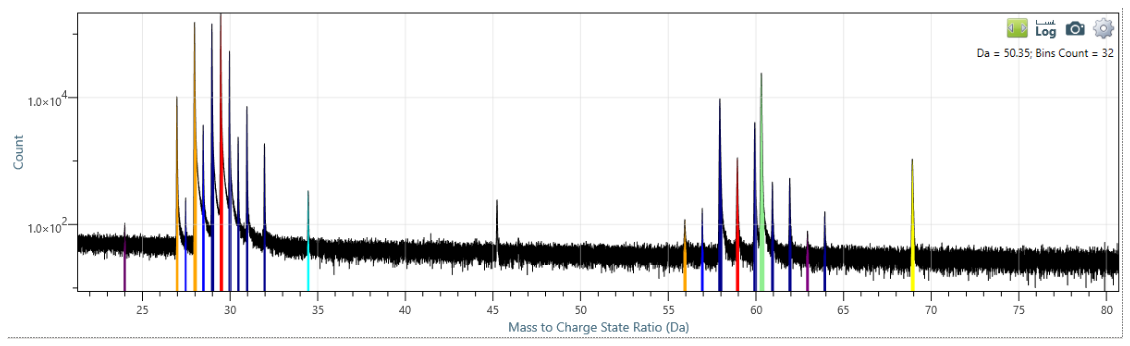

In [95]:
import matplotlib.image as mpimg
img = mpimg.imread('example_IVAS.png')
plt.figure(figsize=(20,40))
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

#Molecular pattern recognizer

In [123]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import matplotlib.pyplot as plt


class Molecular_pattern_recognizer(object):
  def __init__(self):
    pass

  def combine_ions(self, comp_1, comp_2):
      all_ion = []
      all_compo = []
      total_S = comp_1['m']
      compo_S = comp_1['Composition']
  #    start = 0.05
  #    end = 1
  #    
      total_Cu = comp_2['m']
      compo_Cu = comp_2['Composition']
      for i, s in zip(compo_S, total_S) :
          for j, cu in zip(compo_Cu, total_Cu) :
              ion = s+cu
              compo = round(i*j/100,2)
              all_ion.append(ion)
              all_compo.append(compo)
      CuS =  pd.DataFrame(data={'m':all_ion,'Composition':all_compo})   
      CuS = CuS.groupby('m').sum().reset_index()    
      x = CuS[(CuS!= 0).all(1)].reset_index(drop=True)   
      return x

  def molecule_formula(self, *args):
      # print(args)
      temp =  args[0]
      if args[1] >=2:
          for _ in range(1, args[1]):
              temp = self.combine_ions(temp, args[0])
      #        new_temp = temp
      for i in range(2, len(args), 2):
          # print(i)
          # print(len(args))
          # print(args[i])
          if args[i+1]>0:        
              for _ in range(args[i+1]):
                  temp = self.combine_ions(temp, args[i])    
                  
      final=temp[temp['Composition']>1]
      return final


  def molecule_all(self, *args):
      all_molecule = []
      stats = []
      for charge in range(1,5):
          if len(args[1]) == 1:
              for n in range(1,4):  
                  for m in range(0,4):
                      molecule = self.molecule_formula(args[0], n, args[1][0], m)
                      molecule['m'] /= charge
                      all_molecule.append(molecule)
                      # print(molecule)
                      stat = [n, m, charge]
                      stats.append(stat)

          if len(args[1]) == 2:
              for n in range(1, 4):  
                  for m in range(0,4):
                      for a in range(0,4):
                          molecule = self.molecule_formula(args[0], n, args[1][0], m,  args[1][1], a)
                          molecule['m'] /= charge
                          all_molecule.append(molecule)
                          # print(molecule)
                          stat = [n, m, a, charge]
                          stats.append(stat)    
                          
          if len(args[1]) == 3:
              for n in range(1, 4):  
                  for m in range(0, 4):
                      for a in range(0, 4):
                          for b in range(0, 4):
                              molecule = self.molecule_formula(args[0], n, args[1][0], m,  args[1][1], a, args[1][2], b)
                              molecule['m'] /= charge
                              all_molecule.append(molecule)
                              # print(molecule)
                              stat = [n, m, a, b, charge]
                              stats.append(stat)            
      stats= pd.DataFrame(stats)     
      return all_molecule, stats

  def find_good_molecules(self, frame, metals, metals_names, nonmetals, nonmetals_names):  
      all_molecule = []
      stats=[]
      N_metal = []
      total = []
      good_molecules = [] 
      metals_dev=[]
      normalized_Is = []
      MZ_ratio_round = frame['Da'].tolist()
      for N, metal in enumerate(metals):
          all_molecule, stats = self.molecule_all(metal, nonmetals)       
          for i, molecule in enumerate(all_molecule):            
              m = molecule['m'].isin(MZ_ratio_round).tolist()
              index=np.where(m)[0]
              comp_molecule = np.array(molecule['Composition'])[index]
              x = frame[frame['Da'].isin(molecule['m'][m])]
              normalized_I=x['count']/sum(x['count'])*100        
              x['normalized_count'] = normalized_I
              deviation = sum(abs(normalized_I-comp_molecule))
              
              if (sum(comp_molecule) >= 98 and len(comp_molecule) > 0 and deviation <= 20):
                  if (sum(stats.iloc[i][1:])<=10 and sum(stats.iloc[i][1:])>=2):
                      total.append(stats.iloc[i])
                      metals_dev.append(deviation)
                      N_metal.append(N)
                      good_molecules.append(molecule)
                      normalized_Is.append(x)

      total = pd.DataFrame(total)
      total['AME from theory value'] = metals_dev   
      # total['N_metal'] = N_metal     
      total.columns.values[0] = 'metal atoms'
      total.columns.values[len(nonmetals_names)+1] = 'charges'
      Name_metals = []
      for i, name in enumerate(nonmetals_names):
          total.columns.values[i+1] = name
      for j in N_metal:
          Name_metals.append(metals_names[j])
          
      total['metal_names']  =  Name_metals       

      return good_molecules, total

  def molecular_classifier(self, total):
      item = total[0]
      frame=[]
      N=1000
      comps =[]
      delta =0.01
      for n, item in enumerate(total):
          augmented_class = []
          for i in range(N):
              comps=[]
              comp = item['Composition'].tolist()
              for j in range(len(item)):
                  mu, sigma = comp[j], delta*comp[j]
                  s = np.random.normal(mu, sigma, 1)
                  comps.append(s[0])
                  total = sum(comps)
                  if (total<=(sum(comp)+1) and total>=(sum(comp)-1)):
                      augmented_class.append(comps)
          augmented_class= pd.DataFrame(augmented_class)  
          augmented_class['Class'] = n          
          frame.append(augmented_class)        
      data =  pd.concat(frame)             
      X_data = data.drop('Class',axis=1)
      y = data.Class 
      
      print('training test spilting...')
      seed = 7
      test_size = 0.2
      X_train, X_test, y_train, y_test = train_test_split(X_data, y, test_size=test_size, random_state=seed)
      print('start_training...')
      evals_result = {}
      params = {
                "objective" : "multiclass",
                "num_class" : len(frame),
                "num_leaves" : 30,
                "max_depth": 5,
                "learning_rate" : 0.01,
                "bagging_fraction" : 0.9,  # subsample
                "feature_fraction" : 0.9,  # colsample_bytree
                "bagging_freq" : 5,        # subsample_freq
                "bagging_seed" : 20,
                "verbosity" : -1 ,
                'metric':'multi_logloss'}
      lgtrain, lgval = lgb.Dataset(X_train, y_train), lgb.Dataset(X_test, y_test)
      
      model_lgb = lgb.train(params, lgtrain, 2000, valid_sets=[lgtrain, lgval], evals_result=evals_result,
                            early_stopping_rounds=100, verbose_eval=200)
      # print('Plotting metrics recorded during training...')
      # lgb.plot_metric(evals_result, metric='multi_logloss')
      # plt.xlim(0,1000) 
      # plt.show()
      return model_lgb

#Investigation of  standing-alone peak @ 45 Da

In [107]:
Ta = pd.DataFrame(data={'m':[180.0, 181.0],'Composition':[0.012, 99.988]}) 
Al = pd.DataFrame(data={'m':[27],'Composition':[100]}) 
P = pd.DataFrame(data={'m':[31],'Composition':[100]}) 

H = pd.DataFrame(data={'m':[1],'Composition':[100]})
C = pd.DataFrame(data={'m':[12.0, 13.0],'Composition':[98.89, 1.07]}) 
N = pd.DataFrame(data={'m':[14.0, 15.0],'Composition':[99.64, 0.36]}) 


   
metals=[P, Ta ,Al]
metal_names =['P','Ta' ,'Al']
nonmetals = [H, C, N]
nonmetals_names = ['H','C', 'N']

mz_lower_bound = 45
mz_upper_bound = 47
peak_of_interest = MS_frame.loc[(MS_frame['Da']>=mz_lower_bound) & (MS_frame['Da']<=mz_upper_bound)]

print(peak_of_interest)      

       Da  count
34  45.25    246
35  46.50     62


 To be more precise, the peak is at 45.25 Da

In [121]:

molecular_pattern_recognizer = Molecular_pattern_recognizer()
good_molecules, composition_table = molecular_pattern_recognizer.find_good_molecules(peak_of_interest, metals, metal_names, nonmetals, nonmetals_names)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

AME: absolute mean error.
AME from theory -  compuate the AME between the experimental data with computed molecular patterns. 

in this case, the most promising candidates are P_3 2+ or Ta 4+
based on the prior knowledge that this materials system contains littel P, the most likely label for peak @ 45.25 Da is Ta 4+

In [109]:
print(composition_table)

     metal atoms  H  C  N  charges  AME from theory value metal_names
306            2  3  0  2        2                  0.720           P
320            3  0  0  0        2                  0.000           P
576            1  0  0  0        4                  0.012          Ta
324            3  0  1  0        2                  1.110          Al


# molecular classifer

In practice, this are often used when the peak of interest contains multiple peaks and  composition table alone cannot find out which pattern is the most likely candidate i.g., the AME are very close.

Here an example of Cu1S2 and Cu1S1O2 is given

In [124]:
O = pd.DataFrame(data={'m':[16.0, 18.0],'Composition':[99.8, 0.2]})
Cu = pd.DataFrame(data={'m':[63.0, 65.0],'Composition':[69.15, 30.85]})
S = pd.DataFrame(data={'m':[32.0, 33.0, 34.0, 36.0],'Composition':[94.99, 0.75, 4.25, 0.01]})

#if more than one molecular formula 
molecular_pattern_recognizer = Molecular_pattern_recognizer()

x = molecular_pattern_recognizer.molecule_formula(Cu,1,S,2)    
y = molecular_pattern_recognizer.molecule_formula(Cu,1,S,1,O,2)
molecules = [x,y]
molecule_class = True
if molecule_class == True:
   model = molecular_pattern_recognizer.molecular_classifier(molecules)

training test spilting...
start_training...
Training until validation scores don't improve for 100 rounds.
[200]	training's multi_logloss: 0.0704051	valid_1's multi_logloss: 0.0699587
[400]	training's multi_logloss: 0.00982219	valid_1's multi_logloss: 0.00940582
[600]	training's multi_logloss: 0.00149045	valid_1's multi_logloss: 0.00134707
[800]	training's multi_logloss: 0.000241246	valid_1's multi_logloss: 0.000205518
[1000]	training's multi_logloss: 4.18962e-05	valid_1's multi_logloss: 3.54421e-05
[1200]	training's multi_logloss: 8.14769e-06	valid_1's multi_logloss: 8.14944e-06
[1400]	training's multi_logloss: 1.80566e-06	valid_1's multi_logloss: 2.70684e-06
Early stopping, best iteration is:
[1495]	training's multi_logloss: 1.01568e-06	valid_1's multi_logloss: 1.76207e-06



The model is ready to use, input will be the experimental abundance ratio 


probability = model(experimental_abundance_ratio)


In this case, the molecular classifier is not used, since we do not observe any ambiguilty in the composition table.


